# practicalMixGauss_Apples

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Part 1: Model Development (Train)
1.1 Train/Test Split
 
We load the images and their corresponding masks into memory, using two separate sets of data.
The masks are binary, indicating where apples are located. These will later guide the separation of pixel data into "apple" (foreground) and "non-apple" (background).

In [3]:
# Training set: used to train GMMs for apple and non-apple pixel distributions
train_files = [
    'apple_photos/Apples_by_kightp_Pat_Knight_flickr.jpg',
    'apple_photos/ApplesAndPears_by_srqpix_ClydeRobinson.jpg',
    'apple_photos/bobbing-for-apples.jpg'  
]
train_mask_files = [
    'apple_masks/Apples_by_kightp_Pat_Knight_flickr.png',
    'apple_masks/ApplesAndPears_by_srqpix_ClydeRobinson.png',
    'apple_masks/bobbing-for-apples.png'  
]

# Test set: One test image has a ground truth mask, which is used for quantitative evaluation (metrics like TP, TN, FP, FN).
# Test set: The remaining test images are used for qualitative evaluation (visualizing posterior probabilities as heatmaps).
test_files = [
    'apple_photos/Apples_by_MSR_MikeRyan_flickr.jpg',  # No mask
    'apple_photos/audioworm-QKUJj2wmxuI-original.jpg',  # No mask
    'apple_photos/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg'  # Has a mask
]
test_mask_files = ['apple_masks/Bbr98ad4z0A-ctgXo3gdwu8-original.png']  # ground truth

# Helper function to load images and masks
def load_images_and_masks(image_files, mask_files):
    images = [np.array(Image.open(file)) / 255.0 for file in image_files]
    masks = [(np.array(Image.open(file))[:, :, 1] > 128).astype(int) for file in mask_files]
    return images, masks

# Load training, validation, and testing data
train_images, train_masks = load_images_and_masks(train_files, train_mask_files)
test_images, test_masks = load_images_and_masks(test_files, test_mask_files)
# Verify loaded data
print(f"Training set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 3
Test set size: 3


1.2 Feature Extraction: Extract RGB Features

We separates the pixel data into two categories: pixels corresponding to apples and pixels corresponding to non-apples, based on the binary masks. This data becomes the foundation for building the classification model.

In [4]:
# Extract features from training set
apple_pixels = []
non_apple_pixels = []

for img, mask in zip(train_images, train_masks):
    apple_pixels.extend(img[mask == 1].reshape(-1, 3))   # Apple pixels
    non_apple_pixels.extend(img[mask == 0].reshape(-1, 3))  # Non-apple pixels

apple_pixels = np.array(apple_pixels)
non_apple_pixels = np.array(non_apple_pixels)

print(f"Training data: {apple_pixels.shape[0]} apple pixels, {non_apple_pixels.shape[0]} non-apple pixels.")

Training data: 425692 apple pixels, 374608 non-apple pixels.


1.3 Train Gaussian Mixture Models 

Using the pixel data extracted in 1.2, we fit Gaussian Mixture Models (GMMs) for the apple and non-apple pixels in training set. These models learn the distribution of pixel colors for apples and non-apples.

**Note: My implementation currently uses n_components=1 in the fit_gaussian function because:**

1. The data appears to be unimodal, meaning the pixel distribution for apple and non-apple classes **does not exhibit clear sub-clusters or multi-modal behavior**.

2. Using a single Gaussian reduces **the risk of overfitting**, especially since multiple components (n_components > 1) may introduce unnecessary complexity, potentially fitting noise or minor variations in the training data.

3. Additionally, the training dataset may **not have enough samples or diversity to reliably estimate parameters for multiple Gaussian components**, leading to instability or poor generalization to test data.

4. Finally, empirical results showed that n_components=1 **performs better in both test sets given and test images downloaed from online**, capturing the dominant data structure without overcomplicating the model.

In [5]:
# Implement the E-M algorithm to fit two Gaussian models
def fit_gaussian(data, n_components=1, max_iter=100, tol=1e-6):
    n, d = data.shape
    means = np.random.randn(n_components, d)
    covariances = [np.eye(d) for _ in range(n_components)]
    weights = np.ones(n_components) / n_components

    for iteration in range(max_iter):
        # E-step
        responsibilities = np.zeros((n, n_components))
        for k in range(n_components):
            diff = data - means[k]
            cov_inv = np.linalg.inv(covariances[k])
            exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
            norm_factor = np.sqrt((2 * np.pi) ** d * np.linalg.det(covariances[k]))
            responsibilities[:, k] = weights[k] * exp_term / norm_factor
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        weights = responsibilities.sum(axis=0) / n
        for k in range(n_components):
            Nk = responsibilities[:, k].sum()
            means[k] = (responsibilities[:, k][:, None] * data).sum(axis=0) / Nk
            diff = data - means[k]
            covariances[k] = (responsibilities[:, k][:, None] * diff).T @ diff / Nk
            covariances[k] += 1e-6 * np.eye(d)  # Add small value to the diagonal for numerical stability

        # Convergence check
        if iteration > 0 and np.abs(weights - responsibilities.sum(axis=0)).sum() < tol:
            break

    return means, covariances, weights

# Train GMMs
apple_means, apple_covs, apple_weights = fit_gaussian(apple_pixels)
non_apple_means, non_apple_covs, non_apple_weights = fit_gaussian(non_apple_pixels)

1.4 Apply Trained Model to Compute Posterior Probabilities

With the trained Gaussian models, we defined two functions:

1. The `compute_posterior` function computes the posterior probability of each data point (pixel) belonging to a class 
(e.g., apple) using a Gaussian Mixture Model (GMM) and Bayes' theorem. It aggregates weighted likelihoods from all 
Gaussian components based on their means, covariances, and mixture weights, scaled by the class prior probability.

2. The `evaluate` function assesses model performance by applying a fixed threshold (default: 0.5) to the posterior probabilities to classify pixels as apple or non-apple. It computes True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for the given mask, providing metrics for classification performance.

NOTE: We have chosen 0.5 as the optimal threshold here that optitimized our ROC curve performance.

In [6]:
def compute_posterior(data, means, covariances, weights, prior):
    n, d = data.shape
    n_components = len(means)
    likelihoods = np.zeros(n)

    # Compute the likelihoods for the class (P(X | class))
    for k in range(n_components):
        diff = data - means[k]
        cov_inv = np.linalg.inv(covariances[k])
        exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        norm_factor = np.sqrt((2 * np.pi) ** d * np.linalg.det(covariances[k]))
        likelihoods += weights[k] * exp_term / norm_factor  # Sum over Gaussian components

    # Compute posterior probabilities: P(class | X) = (P(X | class) * P(class)) / P(X)
    posteriors = prior * likelihoods  # Numerator: P(X | class) * P(class)

    return posteriors

# Evaluate model performance
def evaluate(mask, posterior, threshold=0.5):
    prediction = posterior > threshold  # Binarize predictions
    tp = np.sum((prediction == 1) & (mask == 1))  # True Positives
    tn = np.sum((prediction == 0) & (mask == 0))  # True Negatives
    fp = np.sum((prediction == 1) & (mask == 0))  # False Positives
    fn = np.sum((prediction == 0) & (mask == 1))  # False Negatives
    return tp, tn, fp, fn

best_threshold = 0.5  # Optimal threshold for classification; pixels with posterior > 0.5 are classified as apple.

1.5 Visualize the Posterior Probabilities Heatmap for one Training set as Example

**On Heatmap:**
- The heatmap effectively illustrates the model's ability to identify apple regions with high confidence, as seen in the bright yellow areas aligning well with the apple pixels. This suggests that the Gaussian model captures the dominant color features of apples.
- The dark regions correspond to the background, correctly classified with low probability, showing the model's ability to differentiate non-apple regions effectively.
- Intermediate regions (e.g., near reflections or edges) have lower probabilities, indicating the model's uncertainty. This is expected in visually complex areas where pixel colors may overlap between classes.


**NOTE:**
1. **Prior Selection**
- The chosen priors (prior_apple=0.6, prior_non_apple=0.4) reflect our assumption that apple pixels are slightly more prevalent in the image than non-apple pixels. This decision was based on the training dataset characteristics.
2. **Normalizing the posterior:**
- It ensures that the probabilities are valid (i.e., they sum to 1 across classes for each pixel). Without normalization, the raw values from the Gaussian likelihoods scaled by priors are not directly interpretable. Normalization allows us to interpret the posterior as P(apple | X), making it suitable for thresholding, visualization, and classification decisions.

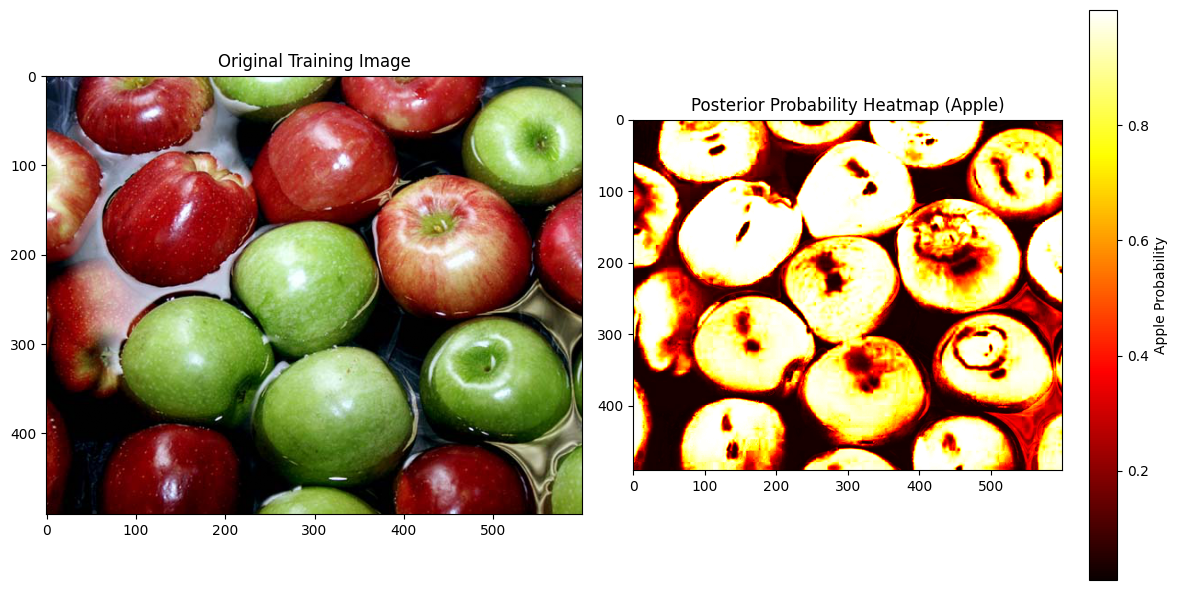

In [7]:
# Define priors
prior_apple = 0.6
prior_non_apple = 0.4

# Select a training image to visualize
image = train_images[-1]  
original_shape = image.shape

# Compute posterior probabilities for apple and non-apple
posterior_apple = compute_posterior(image.reshape(-1, 3), apple_means, apple_covs, apple_weights, prior_apple)
posterior_non_apple = compute_posterior(image.reshape(-1, 3), non_apple_means, non_apple_covs, non_apple_weights, prior_non_apple)

# Normalize posterior probabilities
evidence = posterior_apple + posterior_non_apple
posterior_apple_normalized = posterior_apple / evidence  # P(apple | X)

# Reshape the posterior probabilities back to image dimensions
posterior_image = posterior_apple_normalized.reshape(original_shape[:2])  # Shape (height, width)

# Visualize the original image and the posterior heatmap
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Training Image")
plt.imshow(image)

# Posterior probability heatmap
plt.subplot(1, 2, 2)
plt.title("Posterior Probability Heatmap (Apple)")
plt.imshow(posterior_image, cmap="hot")
plt.colorbar(label="Apple Probability")

plt.tight_layout()
plt.show()

## Part2: Model Evaluation (Test)
2.1 Quantitative Evaluation

Evaluate the model on the test image with a ground truth mask.

Quantitative Results for Test Image with Mask:
TP: 351826, TN: 2276662, FP: 339600, FN: 31912


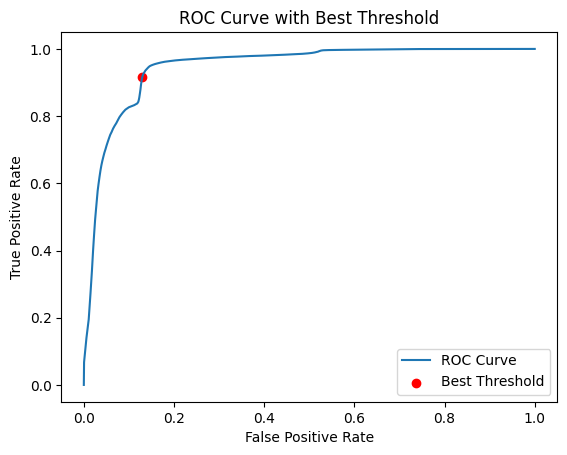

In [8]:
# Select the test image with a ground truth mask
test_image = test_images[-1] 
test_mask = test_masks[0]  
original_shape = test_image.shape[:2]

# Compute unnormalized posteriors for apple and non-apple classes
posterior_apple = compute_posterior(test_image.reshape(-1, 3), apple_means, apple_covs, apple_weights, prior_apple)
posterior_non_apple = compute_posterior(test_image.reshape(-1, 3), non_apple_means, non_apple_covs, non_apple_weights, prior_non_apple)

# Normalize posteriors
evidence = posterior_apple + posterior_non_apple
posterior_apple_normalized = posterior_apple / evidence  # P(apple | X)

# Reshape the normalized posterior to the original image dimensions
posterior_image = posterior_apple_normalized.reshape(original_shape)

# Apply the best threshold from validation
tp, tn, fp, fn = evaluate(test_mask, posterior_image, best_threshold)

print(f"Quantitative Results for Test Image with Mask:")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
 
# Define a function to compute the ROC curve
def compute_roc_curve(true_labels, predicted_probs):
    thresholds = np.linspace(0, 1, 100)  # Generate thresholds from 0 to 1
    tpr = []  # True Positive Rate
    fpr = []  # False Positive Rate

    for threshold in thresholds:
        # Threshold the posterior probabilities
        predictions = (predicted_probs >= threshold).astype(int)

        # Compute TP, FP, TN, FN
        tp = np.sum((predictions == 1) & (true_labels == 1))
        fp = np.sum((predictions == 1) & (true_labels == 0))
        tn = np.sum((predictions == 0) & (true_labels == 0))
        fn = np.sum((predictions == 0) & (true_labels == 1))

        # Calculate TPR and FPR
        tpr.append(tp / (tp + fn + 1e-6)) 
        fpr.append(fp / (fp + tn + 1e-6)) 

    return fpr, tpr

# Flatten the mask and posterior for ROC calculation
true_labels = test_mask.ravel()  # Flatten ground truth mask
predicted_probs = posterior_image.ravel()  # Flatten posterior probabilities

# Compute the ROC curve
fpr, tpr = compute_roc_curve(true_labels, predicted_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(
    [fp / (fp + tn + 1e-6)], [tp / (tp + fn + 1e-6)], 
    color='red', label="Best Threshold"
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Best Threshold")
plt.legend()
plt.show()

**Quantitative Results**:
- The model correctly classified 351,826 apple pixels as true positives (TP) and 2,276,662 non-apple pixels as true negatives (TN).
- It misclassified 339,600 non-apple pixels as false positives (FP), reflecting a higher false positive rate.
- 31912 apple pixels were misclassified as false negatives (FN), showcasing the model's good ability to detect apple pixels.

**Insights from Quantitative Results:**
- The high true positive count and low false negative count indicate the model's good recall, effectively identifying almost all apple pixels in the test image.
- The high false positive count is driven by the threshold of 0.5, which leans towards favoring apple pixel detection but sacrifices precision for non-apple classification.
- This trade-off is acceptable in contexts where capturing all apple pixels is more important than avoiding false alarms (e.g., high recall use cases).

**ROC Curve Analysis:**
- The ROC curve highlights the model’s strong ability to discriminate between apple and non-apple pixels, with a steep initial rise and plateau near the top-left corner.
- The true positive rate (TPR) remains high across a wide range of thresholds, indicating robustness in detecting apple pixels.
- The chosen threshold of 0.5, while balanced, results in a slight precision-recall trade-off. Further threshold optimization (e.g.cross validation) might improve performance depending on the specific application needs.

2.2 Qualitative Evaluation

Visualize posterior heatmaps for test images without ground truth masks.

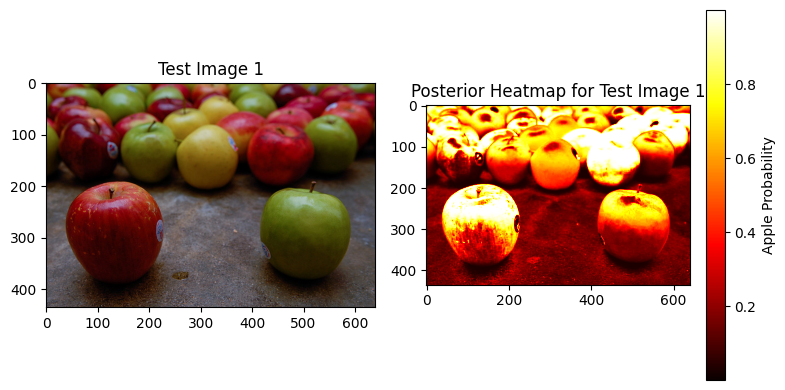

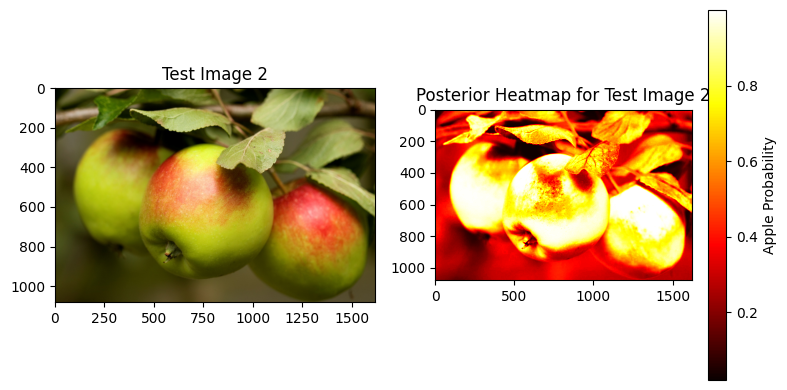

In [10]:
# Qualitative evaluation for test images without ground truth masks
for i in range(len(test_images) - 1):  # Exclude the last image (used for quantitative evaluation)
    test_image = test_images[i]
    original_shape = test_image.shape[:2]

    # Compute unnormalized posteriors for apple and non-apple
    posterior_apple = compute_posterior(test_image.reshape(-1, 3), apple_means, apple_covs, apple_weights, prior_apple)
    posterior_non_apple = compute_posterior(test_image.reshape(-1, 3), non_apple_means, non_apple_covs, non_apple_weights, prior_non_apple)

    # Normalize the posteriors
    evidence = posterior_apple + posterior_non_apple  # P(X)
    posterior_apple_normalized = posterior_apple / evidence  # P(apple | X)

    # Reshape the posterior probabilities back to the image dimensions
    posterior_image = posterior_apple_normalized.reshape(original_shape)

    # Plot the original image and the posterior heatmap
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title(f"Test Image {i + 1}")
    plt.imshow(test_image)

    # Posterior heatmap
    plt.subplot(1, 2, 2)
    plt.title(f"Posterior Heatmap for Test Image {i + 1}")
    plt.imshow(posterior_image, cmap='hot')
    plt.colorbar(label='Apple Probability')

    plt.tight_layout()
    plt.show()

**Heatmap Observations:**

1. **High Confidence Regions:**
- The heatmap shows high-probability regions (yellow & white) aligned well with apple areas in the test image. This indicates the model is effectively detecting apple pixels.

2. **Low Confidence Regions:**
- Non-apple regions (e.g., the background and shadows) are correctly identified with low probabilities (dark red/black), suggesting the model has good specificity.

3. **Uncertainty at Edges:**
- There are intermediate probability values (orange/red) near the boundaries of apples. This reflects the model's uncertainty in distinguishing apple edges from the background. This behavior is expected due to pixel blending or lighting variations.

## Part3: Evaluate Extra Test Images

In [11]:
# Load the new test images and masks separately
new_test_images = ['apple_photos/Beautiful_Apples.png', 'apple_photos/Red_Apples_Fruit_Bowl.png']
new_test_masks = ['apple_masks/Beautiful_Apples_mask.png', 'apple_masks/Red_Apples_Fruit_Bowl_mask.png']

# Load images and masks
test_images_new = [np.array(Image.open(file)) / 255.0 for file in new_test_images]
test_masks_new = [(np.array(Image.open(file))[:, :, 1] > 128).astype(int) for file in new_test_masks]

print(f"Loaded {len(test_images_new)} new test images.")

Loaded 2 new test images.


Shape of image: (799, 1000, 3), Shape of mask: (799, 1000)
Quantitative Results for apple_photos/Beautiful_Apples.png:
TP: 267549, TN: 492667, FP: 1316, FN: 37468
AUC for apple_photos/Beautiful_Apples.png: -0.9851176623804518


C:\Users\44774\AppData\Local\Temp\ipykernel_17992\2260993882.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


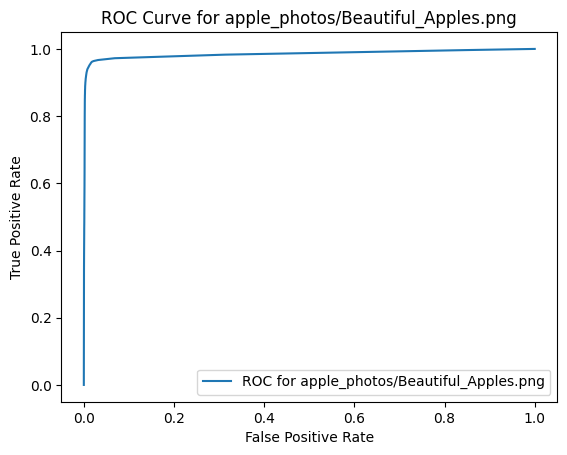

Shape of image: (683, 1024, 3), Shape of mask: (683, 1024)
Quantitative Results for apple_photos/Red_Apples_Fruit_Bowl.png:
TP: 169573, TN: 377532, FP: 68318, FN: 83969
AUC for apple_photos/Red_Apples_Fruit_Bowl.png: -0.8607377305488293


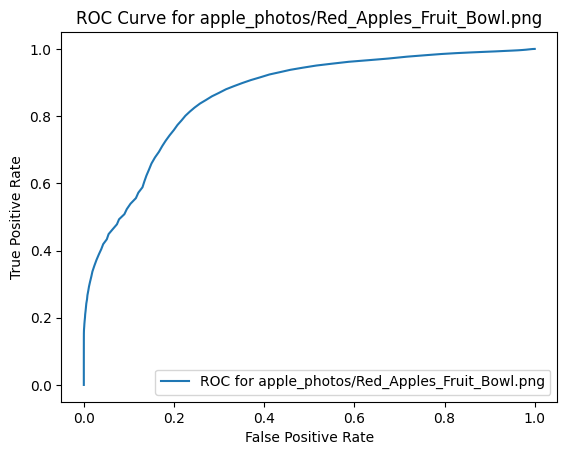

In [12]:
# Quantitative evaluation for each new test image
for i, (image_file, mask_file) in enumerate(zip(new_test_images, new_test_masks), start=1):
    # Load the image and mask
    image = np.array(Image.open(image_file).convert("RGB")) / 255.0  # Ensure 3 channels
    mask = (np.array(Image.open(mask_file))[:, :, 1] > 128).astype(int)  # Load binary mask

    print(f"Shape of image: {image.shape}, Shape of mask: {mask.shape}")

    # Compute unnormalized posteriors for apple and non-apple classes
    posterior_apple = compute_posterior(image.reshape(-1, 3), apple_means, apple_covs, apple_weights, prior_apple)
    posterior_non_apple = compute_posterior(image.reshape(-1, 3), non_apple_means, non_apple_covs, non_apple_weights, prior_non_apple)

    # Normalize the posteriors
    evidence = posterior_apple + posterior_non_apple  # P(X)
    posterior_apple_normalized = posterior_apple / evidence  # P(apple | X)

    # Reshape the posterior probabilities back to the original image dimensions
    posterior_image = posterior_apple_normalized.reshape(mask.shape)

    # Apply the best threshold from validation
    tp, tn, fp, fn = evaluate(mask, posterior_image, best_threshold)

    # Print quantitative results
    print(f"Quantitative Results for {image_file}:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    # Compute TPR and FPR for ROC curve
    true_labels = mask.ravel()
    predicted_probs = posterior_image.ravel()
    fpr, tpr = compute_roc_curve(true_labels, predicted_probs)
    
    auc = np.trapz(tpr, fpr)
    print(f"AUC for {image_file}: {auc}")

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"ROC for {image_file}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {image_file}")
    plt.legend()
    plt.show()

**Quantitative Results**:
1. For Beautiful_Apples.png:
- The model demonstrates excellent performance, with 267,549 true positives (TP) and 492,667 true negatives (TN), indicating that it accurately identifies the majority of apple and non-apple pixels.
- The false positive count (FP) is relatively low at 1,316, suggesting the model effectively avoids misclassifying background regions as apples.
- However, the false negatives (FN) of 37,468 highlight some missed apple pixels, which could arise from subtle apple regions or overlapping edges.

2. For Red_Apples_Fruit_Bowl.png:
- The model detects 169,573 true positives (TP) but has a higher number of false negatives (FN) at 83,969, indicating challenges in identifying all apple pixels in this image.
- True negatives (TN) are strong at 377,532, but the false positive count (FP) of 68,318 reveals difficulties in distinguishing non-apple regions, likely due to visually similar objects or complex backgrounds.

**ROC Curve Insights:**
1. For Beautiful_Apples.png:
- The ROC curve rises steeply, indicating the model achieves a high true positive rate (TPR) with a low false positive rate (FPR), reflecting robust discrimination between apple and non-apple pixels.

2. For Red_Apples_Fruit_Bowl.png:
- The flatter shape of the ROC curve suggests the model struggles to achieve a high TPR without incurring a significant FPR.
- This performance gap highlights the complexity of this image, where similar-colored background elements and clutter make accurate segmentation more difficult.


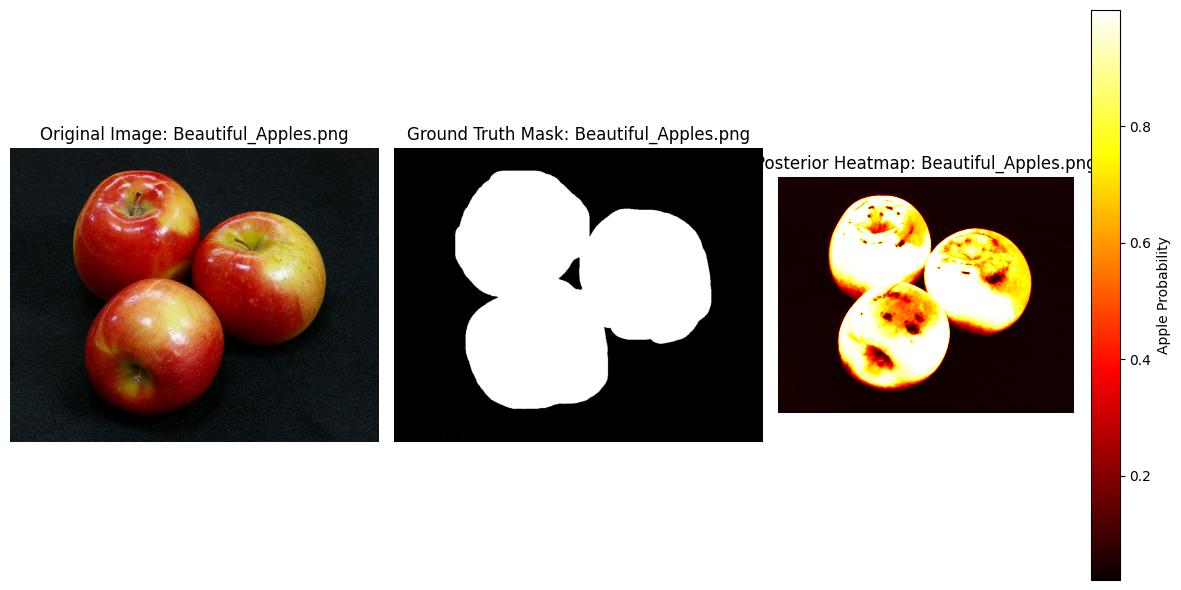

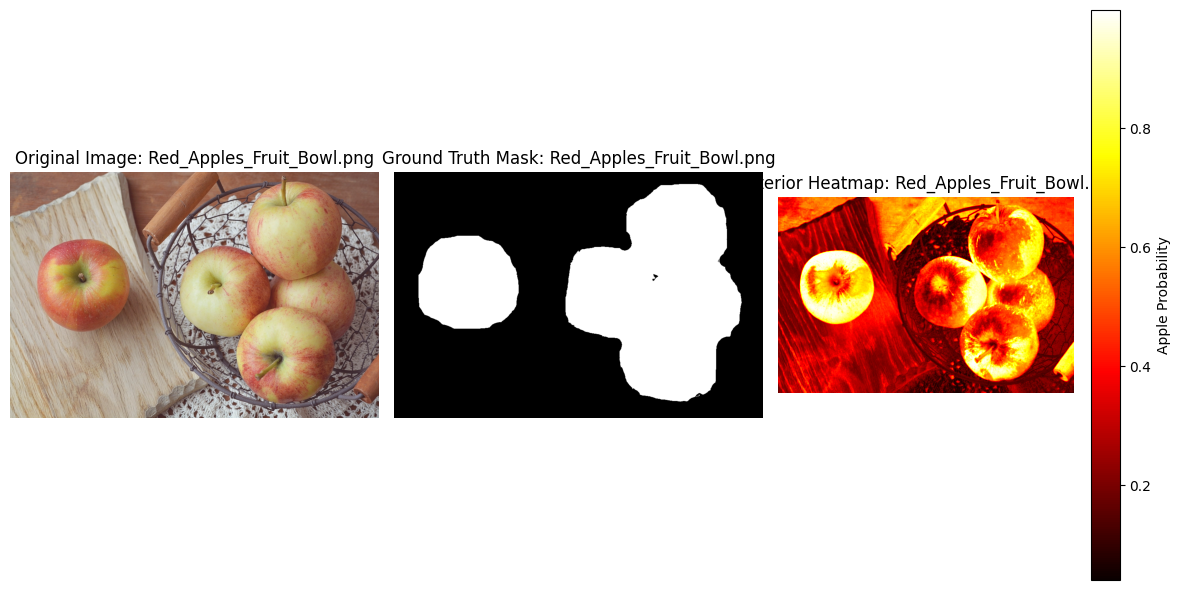

In [13]:
# Qualitative evaluation: Visualize results for both test images
for i, (image_file, mask_file) in enumerate(zip(new_test_images, new_test_masks), start=1):
    # Load the image and mask
    image = np.array(Image.open(image_file).convert("RGB")) / 255.0  # Ensure 3 channels
    mask = (np.array(Image.open(mask_file))[:, :, 1] > 128).astype(int)  # Load binary mask

    # Compute unnormalized posteriors for apple and non-apple
    posterior_apple = compute_posterior(image.reshape(-1, 3), apple_means, apple_covs, apple_weights, prior_apple)
    posterior_non_apple = compute_posterior(image.reshape(-1, 3), non_apple_means, non_apple_covs, non_apple_weights, prior_non_apple)

    # Normalize the posteriors
    evidence = posterior_apple + posterior_non_apple  # P(X)
    posterior_apple_normalized = posterior_apple / evidence  # P(apple | X)

    # Reshape the posterior probabilities back to the original image dimensions
    posterior_image = posterior_apple_normalized.reshape(mask.shape)

    # Plot original image, ground truth mask, and posterior heatmap
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title(f"Original Image: {image_file.split('/')[-1]}")
    plt.imshow(image)
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth Mask: {image_file.split('/')[-1]}")
    plt.imshow(mask, cmap="gray")
    plt.axis('off')

    # Posterior Probability Heatmap
    plt.subplot(1, 3, 3)
    plt.title(f"Posterior Heatmap: {image_file.split('/')[-1]}")
    plt.imshow(posterior_image, cmap="hot")
    plt.colorbar(label="Apple Probability")
    plt.axis('off')

    # Show all plots
    plt.tight_layout()
    plt.show()

**Heatmap:**
1. Comments for Beautiful_Apples.png plot:
- The posterior heatmap effectively highlights apple regions with high confidence (bright yellow areas) and aligns well with the ground truth mask.
- Low-probability regions (dark areas) correctly represent the background, showing good model performance.
- Minor uncertainties around apple edges and reflections suggest areas for improvement, possibly through additional preprocessing or more robust features.

2. Comments for Red_Apples_Fruit_Bowl.png plot:
- The posterior heatmap captures most apple regions but struggles slightly with differentiating apples from the visually complex background.
- Bright regions align reasonably well with the ground truth mask, though some misclassifications in the darker background are noticeable.
- The challenges here highlight the need for improved handling of cluttered scenes or similar-colored non-apple regions.

## Why should we be using training - validation - test sets? 
**Ans**: 

Including a validation set is important for fine-tuning model parameters, such as selecting the optimal threshold for producing TP/TN/FP/FN from the posterior probabilities and selecting the optimal number of components in GMMs, without biasing the model toward the test set. The validation set acts as an intermediary, allowing us to evaluate the model's performance on unseen data during development and adjust hyperparameters, like the threshold, to maximize metrics such as precision, recall, or F1 score. Without a validation set, using the test set for this purpose would compromise its role as an unbiased measure of the model's final performance, leading to overfitting and unreliable results.